# Divvy Bike Repositioning Project





In [1]:
from gurobipy import *
from datascience import *
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')
import math
import seaborn as sns
import datetime
import folium
import pandas as pd
!pip install haversine
import haversine as hs #package to caculate latitude and longtitude . distance. 



 ### Table of Contents

* [Section I: Introduction](#1)
* [Section II: Data Analysis](#2)
    * [Section A:Statistical Analysis](#Section_A)
    * [Section B:Data Visualization](#Section_B)
    * [Section C:Findings](#Section_C)

* [Section III: Model](#3)
    * [Sensitivity Analysis](#Sensitivity_Analysis)
    
* [Section V: Model Analysis and Managerial Insights](#4)
* [Section VI: Conclusion](#5)
* [Author Contributions](#6)



# 1 

# Introduction

It is early 2018 and the CEO of Chicago Divvy, Juan Serpa, is sitting at his desk reflecting on another year for the bike-sharing program. Divvy, as a program of the Chicago Department of Transportation (CDOT), aims to promote economic recovery, reduce traffic congestion and improve the air quality of the city. Its service opens to residents and visitors in Chicago a convenient and affordable transportation option for getting to the workplace, visiting and exploring the city. Such a new system faces many uncertainties and precise indicators in its operation, for instance, the overall design of the system, the selection of specific station locations and dock installation, and the operational expense. 

Juan decided to hire a team of data scientists, who were experts in optimization and Python, to help him solve the operational challenges that Divvy faces. In particular, he would like to have the bike repositioning scheme and cost, the location of new docking stations, the number of extra bikes needed, the pricing of membership, to better make its bike-share site planning decisions. 


# 1.1 Data Polishment

## Data Polishment Process

#### The original table of the Divvy trips in the third quarter, 2017.

In [13]:
station_Q3=Table.read_table("Divvy_Trips_2017_Q3.csv")
station_Q3.show(3)

trip_id,start_time,end_time,bikeid,tripduration,from_station_id,from_station_name,to_station_id,to_station_name,usertype,gender,birthyear
16734065,9/30/2017 23:59:58,10/1/2017 00:05:47,1411,349,216,California Ave & Division St,259,California Ave & Francis Pl,Subscriber,Male,1985
16734064,9/30/2017 23:59:53,10/1/2017 00:05:47,3048,354,216,California Ave & Division St,259,California Ave & Francis Pl,Subscriber,Male,1979
16734063,9/30/2017 23:59:06,10/1/2017 00:02:52,2590,226,141,Clark St & Lincoln Ave,144,Larrabee St & Webster Ave,Subscriber,Male,1993


#### The original table of the Divvy trips in the forth quarter, 2017.

In [3]:
station_Q4=Table.read_table("Divvy_Trips_2017_Q4.csv")
station_Q4.show(3)

trip_id,start_time,end_time,bikeid,tripduration,from_station_id,from_station_name,to_station_id,to_station_name,usertype,gender,birthyear
17536701,12/31/2017 23:58,1/1/2018 0:03,3304,284,159,Claremont Ave & Hirsch St,69,Damen Ave & Pierce Ave,Subscriber,Male,1988
17536700,12/31/2017 23:54,1/1/2018 0:18,5975,1402,145,Mies van der Rohe Way & Chestnut St,145,Mies van der Rohe Way & Chestnut St,Customer,nan,nan
17536699,12/31/2017 23:54,1/1/2018 0:18,4906,1441,145,Mies van der Rohe Way & Chestnut St,145,Mies van der Rohe Way & Chestnut St,Customer,nan,nan


#### To better illustrate and interpret the data and the graphs, we added two columns into the table, which are the trip duration in minutes, and the customer's age. The new table is named as 'station_Q3_update'.

In [34]:
#change the unit to minutes:
station_Q3_update=Table()
station_Q3_update=station_Q3_update.with_columns(station_Q3.select(0,1,2,3,4))
station_Q3_update=station_Q3_update.with_columns("trip_duration_min",station_Q3["tripduration"]/60)
station_Q3_update=station_Q3_update.with_columns(station_Q3.select(5,6,7,8,9,10,11))
station_Q3_update=station_Q3_update.with_columns("age",2017-station_Q3["birthyear"])

#### Updated table for the Divvy trip in the third quarter, 2017.

In [35]:
station_Q3_update.show(3)

trip_id,start_time,end_time,bikeid,tripduration,trip_duration_min,from_station_id,from_station_name,to_station_id,to_station_name,usertype,gender,birthyear,age
16734065,9/30/2017 23:59:58,10/1/2017 00:05:47,1411,349,5.81667,216,California Ave & Division St,259,California Ave & Francis Pl,Subscriber,Male,1985,32
16734064,9/30/2017 23:59:53,10/1/2017 00:05:47,3048,354,5.9,216,California Ave & Division St,259,California Ave & Francis Pl,Subscriber,Male,1979,38
16734063,9/30/2017 23:59:06,10/1/2017 00:02:52,2590,226,3.76667,141,Clark St & Lincoln Ave,144,Larrabee St & Webster Ave,Subscriber,Male,1993,24


#### Updated table for the Divvy trip in the forth quarter, 2017.

In [36]:
station_Q4_update=Table()
station_Q4_update=station_Q4_update.with_columns(station_Q4.select(0,1,2,3,4))
station_Q4_update=station_Q4_update.with_columns("trip_duration_min",station_Q4["tripduration"]/60)
station_Q4_update=station_Q4_update.with_columns(station_Q4.select(5,6,7,8,9,10,11))
station_Q4_update=station_Q4_update.with_columns("age",2017-station_Q4["birthyear"])

In [37]:
station_Q4_update.show(3)

trip_id,start_time,end_time,bikeid,tripduration,trip_duration_min,from_station_id,from_station_name,to_station_id,to_station_name,usertype,gender,birthyear,age
17536701,12/31/2017 23:58,1/1/2018 0:03,3304,284,4.73333,159,Claremont Ave & Hirsch St,69,Damen Ave & Pierce Ave,Subscriber,Male,1988,29
17536700,12/31/2017 23:54,1/1/2018 0:18,5975,1402,23.3667,145,Mies van der Rohe Way & Chestnut St,145,Mies van der Rohe Way & Chestnut St,Customer,nan,nan,nan
17536699,12/31/2017 23:54,1/1/2018 0:18,4906,1441,24.0167,145,Mies van der Rohe Way & Chestnut St,145,Mies van der Rohe Way & Chestnut St,Customer,nan,nan,nan


#### To examine the distribution of all trip durations, we plot the trip IDs against the durations in one scatter plot.

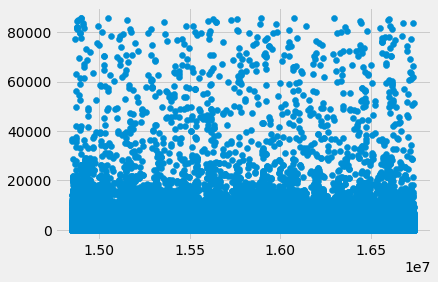

In [38]:
# scatter plot of Q3
plots.scatter(station_Q3['trip_id'],station_Q3['tripduration']);

#### The scatter plot of the forth quarter.

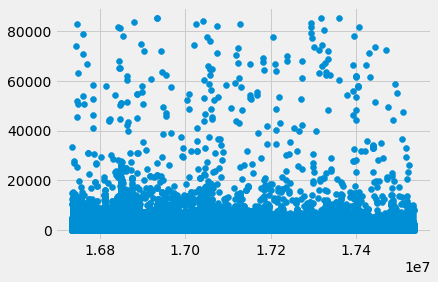

In [39]:
# scatter plot of Q4
plots.scatter(station_Q4['trip_id'],station_Q4['tripduration']);

From these two scatter plots, we observed that there is a lot of outliers above 20000 that in fact have very small probablity to happen. For instance, the trip with 80000 seconds (which equal to 22hours ) could be regarded as very random event, and could hinder our study. Therefore, we decide to consider trips withinin 20000s, and remove the rows with the trip duration that is larger than 1440 minutes.

#### The updated scatter plot of the third quarter.

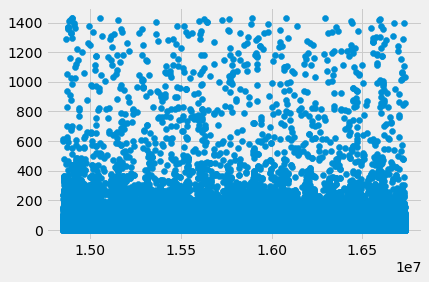

In [40]:
plots.scatter(station_Q3_update['trip_id'],station_Q3_update['trip_duration_min']);

#### The updated scatter plot of the forth quarter.

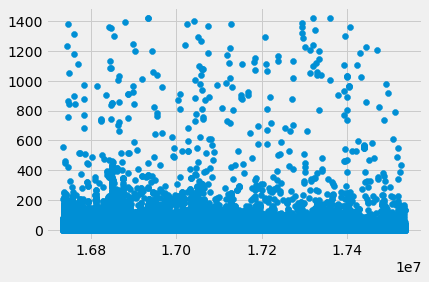

In [41]:
plots.scatter(station_Q4_update['trip_id'],station_Q4_update['trip_duration_min']);

#### In order to get better prediction, we excluded the trip durations that are larger than 4500/3500s to reduce the presence of outliers. 

After have made this change, we observed that the distribution is skewed to the right. Therefore, we would only consider the right-hand sided outliers in our analysis. We set our boundary to be two standard deviations above the mean to get a 95% percentile of our data.

In [42]:
#outlier_q3_boundary=q3_mean+2*q3_sd
#outlier_q3_boundary
#outlier_q4_boundary=q4_mean+2*q4_sd
#outlier_q4_boundary
#after estimation:
q3_right_boundary=4274
q4_right_boundary=3393
station_Q3_update=station_Q3_update.where(station_Q3_update['tripduration']<=4500)
station_Q4_update=station_Q4_update.where(station_Q4_update['tripduration']<=3500)

In [43]:
station_Q3_update

trip_id,start_time,end_time,bikeid,tripduration,trip_duration_min,from_station_id,from_station_name,to_station_id,to_station_name,usertype,gender,birthyear,age
16734065,9/30/2017 23:59:58,10/1/2017 00:05:47,1411,349,5.81667,216,California Ave & Division St,259,California Ave & Francis Pl,Subscriber,Male,1985,32
16734064,9/30/2017 23:59:53,10/1/2017 00:05:47,3048,354,5.9,216,California Ave & Division St,259,California Ave & Francis Pl,Subscriber,Male,1979,38
16734063,9/30/2017 23:59:06,10/1/2017 00:02:52,2590,226,3.76667,141,Clark St & Lincoln Ave,144,Larrabee St & Webster Ave,Subscriber,Male,1993,24
16734062,9/30/2017 23:58:56,10/1/2017 00:07:37,551,521,8.68333,96,Desplaines St & Randolph St,217,Racine Ave (May St) & Fulton St,Customer,nan,nan,nan
16734061,9/30/2017 23:58:47,10/1/2017 00:07:37,1287,530,8.83333,96,Desplaines St & Randolph St,217,Racine Ave (May St) & Fulton St,Subscriber,Female,1994,23
16734060,9/30/2017 23:58:45,10/1/2017 00:16:37,6132,1072,17.8667,478,Rockwell St & Eastwood Ave,117,Wilton Ave & Belmont Ave,Subscriber,Male,1980,37
16734059,9/30/2017 23:57:19,10/1/2017 00:05:36,5235,497,8.28333,114,Sheffield Ave & Waveland Ave,296,Broadway & Belmont Ave,Subscriber,Male,1988,29
16734058,9/30/2017 23:57:12,10/1/2017 00:00:46,54,214,3.56667,87,Racine Ave & Fullerton Ave,127,Lincoln Ave & Fullerton Ave,Subscriber,Male,1977,40
16734057,9/30/2017 23:56:59,10/1/2017 00:20:17,3823,1398,23.3,90,Millennium Park,86,Eckhart Park,Customer,nan,nan,nan
16734056,9/30/2017 23:56:52,10/1/2017 00:14:44,5794,1072,17.8667,296,Broadway & Belmont Ave,268,Lake Shore Dr & North Blvd,Subscriber,Female,1990,27


In [44]:
station_Q4_update

trip_id,start_time,end_time,bikeid,tripduration,trip_duration_min,from_station_id,from_station_name,to_station_id,to_station_name,usertype,gender,birthyear,age
17536701,12/31/2017 23:58,1/1/2018 0:03,3304,284,4.73333,159,Claremont Ave & Hirsch St,69,Damen Ave & Pierce Ave,Subscriber,Male,1988,29
17536700,12/31/2017 23:54,1/1/2018 0:18,5975,1402,23.3667,145,Mies van der Rohe Way & Chestnut St,145,Mies van der Rohe Way & Chestnut St,Customer,nan,nan,nan
17536699,12/31/2017 23:54,1/1/2018 0:18,4906,1441,24.0167,145,Mies van der Rohe Way & Chestnut St,145,Mies van der Rohe Way & Chestnut St,Customer,nan,nan,nan
17536698,12/31/2017 23:48,12/31/2017 23:53,5667,315,5.25,340,Clark St & Wrightwood Ave,143,Sedgwick St & Webster Ave,Subscriber,Male,1963,54
17536697,12/31/2017 23:42,12/31/2017 23:47,5353,272,4.53333,240,Sheridan Rd & Irving Park Rd,245,Clarendon Ave & Junior Ter,Subscriber,Male,1977,40
17536696,12/31/2017 23:41,12/31/2017 23:51,5840,589,9.81667,93,Sheffield Ave & Willow St,343,Racine Ave & Wrightwood Ave,Subscriber,Male,1988,29
17536695,12/31/2017 23:34,12/31/2017 23:39,6351,301,5.01667,337,Clark St & Chicago Ave,182,Wells St & Elm St,Subscriber,Male,1990,27
17536694,12/31/2017 23:21,12/31/2017 23:23,2562,141,2.35,226,Racine Ave & Belmont Ave,117,Wilton Ave & Belmont Ave,Subscriber,Male,1987,30
17536693,12/31/2017 23:17,12/31/2017 23:27,2471,615,10.25,49,Dearborn St & Monroe St,26,McClurg Ct & Illinois St,Subscriber,Male,1981,36
17536692,12/31/2017 22:57,12/31/2017 23:09,6462,743,12.3833,196,Cityfront Plaza Dr & Pioneer Ct,255,Indiana Ave & Roosevelt Rd,Subscriber,Male,1980,37


#### The following two graphs show the difference among the trip duration between the two quarters.

We observed that the trip duration and frequency in the third quarter (which it is in the Fall), are both greater than in the forth quarter (in the Winter). 

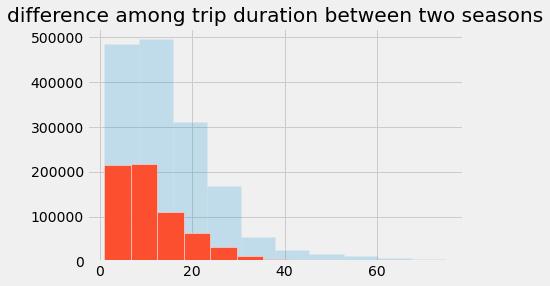

In [45]:
#Q3-Q4 comparision.
x=station_Q3_update['bikeid']
y=station_Q3_update['trip_duration_min']
a=station_Q4_update['bikeid']
b=station_Q4_update['trip_duration_min']
plots.hist(y,alpha=0.2)
plots.hist(b,alpha=1)
plots.title('difference among trip duration between two seasons');

# 2

#  Data Analyisis

## Section_A

## Statistical Analysis

#### The mean of the Divvy trip in the third quarter, 2017.

In [46]:
q3_mean=station_Q3["tripduration"].mean()
q3_mean

1044.2485067805778

#### The mean of the Divvy trip in the forth quarter, 2017.

In [47]:
q4_mean=station_Q4["tripduration"].mean()
q4_mean

779.4404988352442

#### The minimum trip duration (in minutes) in the third quarter, 2017.

In [48]:
q3_min=station_Q3["tripduration"].min()
q3_min

60

#### The minimum trip duration (in minutes) in the forth quarter, 2017.

In [49]:
q4_min=station_Q4["tripduration"].min()
q4_min

60

#### The maximum trip duration (in minutes) in the third quarter, 2017.

In [50]:
q3_max=station_Q3["tripduration"].max()
q3_max

86014

#### The maximum trip duration (in minutes) in the forth quarter, 2017.

In [51]:
q4_max=station_Q4["tripduration"].max()
q4_max

85466

#### The standard deviation of the trip duration in the third quarter, 2017.

In [52]:
q3_sd=station_Q3["tripduration"].std()
q3_sd

1614.8375306989499

#### The standard deviation of the trip duration in the forth quarter, 2017.

In [53]:
q4_sd=station_Q4["tripduration"].std()
q4_sd

1307.233208737884

#### The updated total number of trips in the third quarter, 2017.

In [54]:
#the number of update row
number_of_orginal_Q3=len(station_Q3["tripduration"])
number_of_update_Q3=len(station_Q3_update["tripduration"])

number_of_update_Q3

1581290

#### The updated total number of trips in the forth quarter, 2017.¶

In [55]:
number_of_orginal_Q4=len(station_Q4["tripduration"])
number_of_update_Q4=len(station_Q4_update["tripduration"])
number_of_update_Q4

661446

### The table below shows the statistical facts of the trip data in the third and forth quarter.

In [56]:
statistical_fact=Table().with_columns("Seasons",make_array("Q3","Q4"),
                                     "Mean",make_array(q3_mean,q4_mean),
                                     "Minimum",make_array(q3_min,q4_min),
                                     "Maximum",make_array(q3_max,q4_max),
                                     "Standard Deviation",make_array(q3_sd,q4_sd))
statistical_fact

Seasons,Mean,Minimum,Maximum,Standard Deviation
Q3,1044.25,60,86014,1614.84
Q4,779.44,60,85466,1307.23


**Seasonality:**
There are obvious decreases in mean and standard deviation of the trip duration from Q3 to Q4, which can be explained by the decrease in desire to bike in colder weather.

#### To find out how often the bikes are used, the vacancy ratio is introduced. To better visualize our data, we imported the files as dataframe.

**Vacancy rate** = 1 - Total seconds of trip durations of one bike / Total time of one quarter

In [57]:
#vacancy_rate:using dataframe.
#import file as dataframe.
Q3=pd.read_csv("D:\Lecture5\Divvy_Trips_2017_Q3.csv")
Q4=pd.read_csv("D:\Lecture5\Divvy_Trips_2017_Q4.csv")

In [58]:
# vacancy rate by pandas for Q3
use_rate_Q3=Q3['tripduration'].groupby(Q3['bikeid']).sum()/7776000
vacancy_rate_Q3=1-use_rate_Q3
vacancy_rate_Q3
vacancy_rate_Q3.mean()

0.9623537499973083

In [59]:
# vacancy rate by pandas for Q4
use_rate_Q4=Q4['tripduration'].groupby(Q4['bikeid']).sum()/7776000
vacancy_rate_Q4=1-use_rate_Q4
vacancy_rate_Q4
vacancy_rate_Q4.mean()

0.9886281908874838

In [60]:
Q4_average = sum(vacancy_rate_Q4)/len(vacancy_rate_Q4)
Q3_average = sum(vacancy_rate_Q3)/len(vacancy_rate_Q3)
(Q3_average-0.33,Q4_average-0.33)

(0.6323537499973082, 0.6586281908874838)

Even if we substract from the average vacancy rate 33% of the daytime (22pm - 6am), when most customers are not active, the vacancy rates in both quarters are still very high at a level of approximately 64%, entailing that Divvy bikes are not used 64% of the time. Since there are 6471 bikes in total and Chicago has a population of 2.7m (2017, US cenus bureau), we conclude that there is a great potential for Divvy bikes to expand its consumer base. 

# Section_B

## Data Visualization

#### The following two charts are the histogram of the trip duration (in minutes) in the third and forth quarters.

Text(0.5, 0, 'minutes')

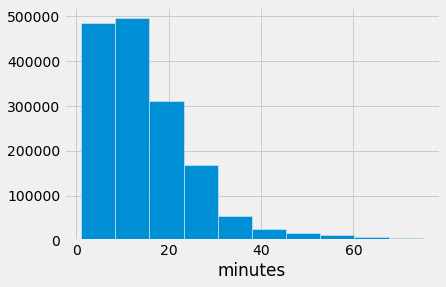

In [61]:
#hist chart:
plots.hist(station_Q3_update["trip_duration_min"]);
plots.xlabel("minutes")

Text(0.5, 0, 'minutes')

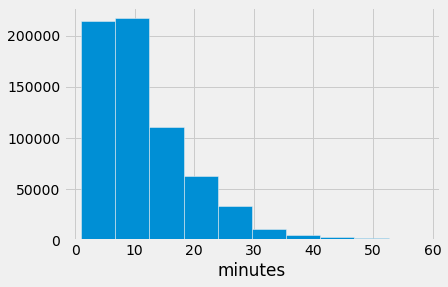

In [62]:
plots.hist(station_Q4_update['trip_duration_min']);
plots.xlabel("minutes")

From the histogram in the third quarter, we observed that the riding time of most of customers is within 20 minutes, which is longer than the riding time in the forth quarter. This phenomenon happened due to the weather, that it is warmer to ride bikes in the fall than in the winter.

#### The following two charts are the histogram of the customers' age in the third and forth quarters.

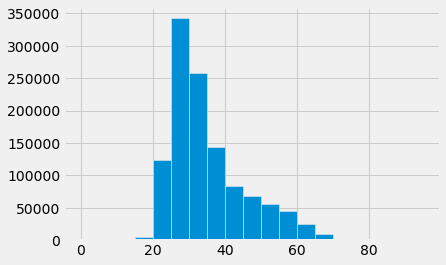

In [63]:
#age_histogram
plots.hist(station_Q3_update["age"],bins=np.arange(0,100,5));

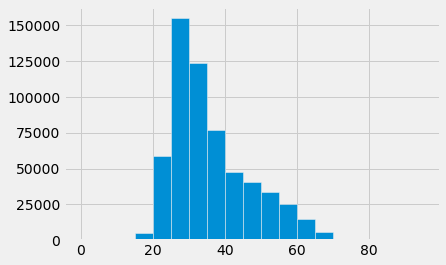

In [64]:
plots.hist(station_Q4_update["age"],bins=np.arange(0,100,5));

From these two histograms, we observed that the majority age group who chooses to use bike as their mean of transportation is between 25 to 40 years old. Therefore, we can conclude that the bike-sharing program is more attractive to younger workers than the senior workers, as they just enter to the workplace and have relatively low income. The senior customers may choose to ride bikes for exploring the city or doing exercises.

#### The following two charts are the histogram of the bike's usage frequency within a day in the third and forth quarters.

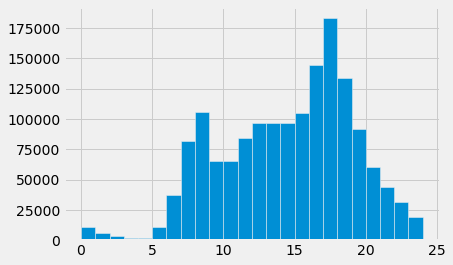

In [65]:
#start_time_hist
def get_hour_Q3(time):
    return int(time[-8:-6])
Q3_start_array=station_Q3_update.apply(get_hour_Q3,'start_time')
station_Q3_temp2=station_Q3_update.with_columns("start_time_hour",Q3_start_array)
    
plots.hist(station_Q3_temp2["start_time_hour"],bins=np.arange(0,25,1));

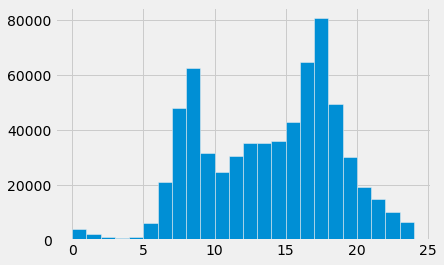

In [66]:
def get_hour_Q4(time):
    if time[-5]=="":
        hour=int(time[-4])
    else:
        hour=int(time[-5:-3])
    return hour
Q4_start_array=station_Q4_update.apply(get_hour_Q4,'start_time')
station_Q4_temp=station_Q4_update.with_columns("start_time_hour",Q4_start_array)
plots.hist(station_Q4_temp["start_time_hour"],bins=np.arange(0,25,1));

From these two histograms, we observed that there are two peak time ranges in a day that bikes got used the most, which are from 7am to 9am, and from 4pm to 7pm. These two time ranges are the peak hours for people go to school and workplace. Based on this information, we should carefully consider the location of new docking stations and the number of extra bikes needed to meet the usage demand.

#### The following two charts are the pie chart of the gender of users in the third and forth quarters.

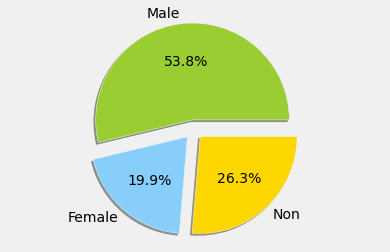

In [67]:
#pie chart for user type sort by gender 
#Q3
#Data Input 
male = len(station_Q3_update.where('gender',are.equal_to('Male')).column('gender'))
female = len(station_Q3_update.where('gender',are.equal_to('Female')).column('gender'))
nan = len(station_Q3_update.where('gender',are.equal_to('nan')).column('gender'))
gender_inputs_Q3 = [male,female,nan]
#Pie Chart Building
explode = [0.1,0.1,0.1]
bar_labels = ['Male','Female','Non']
pie_colors = ['yellowgreen', 'lightskyblue','gold']

plots.pie(gender_inputs_Q3, labels=bar_labels, autopct='%1.1f%%',colors=pie_colors, explode=explode, shadow = True);

plots.axis('equal');

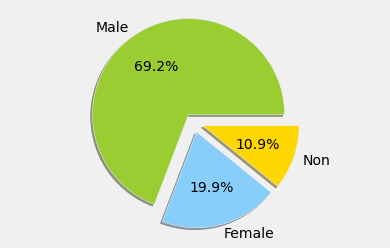

In [68]:
#Q4
#Data Input 
male = len(station_Q4_update.where('gender',are.equal_to('Male')).column('gender'))
female = len(station_Q4_update.where('gender',are.equal_to('Female')).column('gender'))
nan = len(station_Q4_update.where('gender',are.equal_to('nan')).column('gender'))
gender_inputs_Q4 = [male,female,nan]
#Pie Chart Building
explode = [0.1,0.1,0.1]
bar_labels = ['Male','Female','Non']
pie_colors = ['yellowgreen', 'lightskyblue','gold']

plots.pie(gender_inputs_Q4, labels=bar_labels, autopct='%1.1f%%',colors=pie_colors, explode=explode, shadow = True);

plots.axis('equal');

Based on the pie charts, we can conclude that there are more male users than female users. It is a reasonable result that women were more likely to be occasional cyclists, while men were more likely to be regular cyclists. In addition, women were more concerned about safety and being able to carry daily items than men, so they may not willing to ride bike to go to the restaurant or the workplace.

#### The following two charts are the pie chart of the type of users in the third and forth quarters.

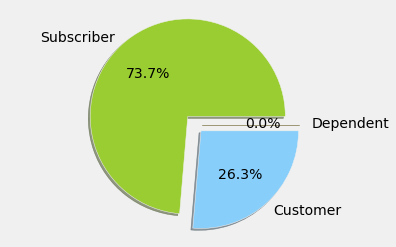

In [69]:
#pie_chart by user type:
#user_typeQ3
#Data Input 
Subscriber = len(station_Q3_update.where('usertype',are.equal_to('Subscriber')).column('usertype'))
Customer = len(station_Q3_update.where('usertype',are.equal_to('Customer')).column('usertype'))
Dependent = len(station_Q3_update.where('usertype',are.equal_to('Dependent')).column('usertype'))
user_type_Q3 = [Subscriber,Customer,Dependent]
#Pie Chart Building
explode = [0.1,0.1,0.1]
bar_labels = ['Subscriber','Customer','Dependent']
pie_colors = ['yellowgreen', 'lightskyblue','gold']

plots.pie(user_type_Q3, labels=bar_labels, autopct='%1.1f%%',colors=pie_colors, explode=explode, shadow = True);

plots.axis('equal');

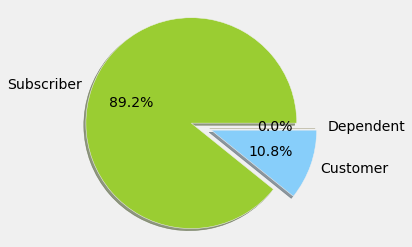

In [70]:
#User_typeQ4
#Data Input 
Subscriber = len(station_Q4_update.where('usertype',are.equal_to('Subscriber')).column('usertype'))
Customer = len(station_Q4_update.where('usertype',are.equal_to('Customer')).column('usertype'))
Dependent = len(station_Q4_update.where('usertype',are.equal_to('Dependent')).column('usertype'))
user_type_Q4 = [Subscriber,Customer,Dependent]
#Pie Chart Building
explode = [0.1,0.1,0.1]
bar_labels = ['Subscriber','Customer','Dependent']
pie_colors = ['yellowgreen', 'lightskyblue','gold']

plots.pie(user_type_Q4, labels=bar_labels, autopct='%1.1f%%',colors=pie_colors, explode=explode, shadow = True);

plots.axis('equal');

From the pie charts, we observed that most of users are subscribers. The current subscribing fee is 108/year. 
These results, combined with the fact that Divvy bikes have a very high vacancy rate, suggest that there is great potential to boost revenue if Divvy invests more in marketing or lower the subscription fee to attract more local subscribers. The company can focus more on marketing strategies or finding sponsorship with more companies.

#### The number of stations in the year of 2013, 2014, 2015, 2016, and 2017.

id,name,city,latitude,longitude,dpcapacity,online_date,Unnamed: 7,start_year
2,Buckingham Fountain,Chicago,41.8764,-87.6203,27,6/10/2013 10:43,nan,2013
3,Shedd Aquarium,Chicago,41.8672,-87.6154,55,6/10/2013 10:44,nan,2013
4,Burnham Harbor,Chicago,41.8563,-87.6133,23,6/10/2013 10:46,nan,2013


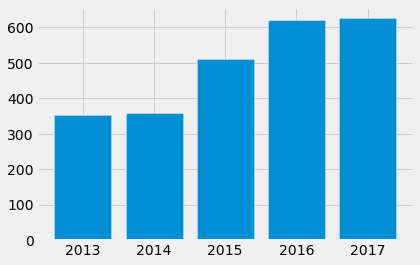

In [71]:
#station in each year.
stations = Table.read_table('Divvy_Stations_2017_Q3Q4.csv')
def get_year(time):
    if time[-6]==" ":
        year=time[-10:-6]
    else:
        year=time[-9:-5]
    return year
year_array=stations.apply(get_year,'online_date')
stations_temp=stations.with_columns("start_year",year_array)
stations_temp.show(3)

plots.bar(stations_temp['start_year'],stations_temp['id']);

From the histogram, we see that the number of stations has doubled from 2014 to 2017. As the number of our users increases every year, we have to get a better prediction and estimation for next year on the number of stations and its location to minimize the company's operational cost.

In [72]:
#Heat Map of Stations:
station_Q3 =Table.read_table('Divvy_Trips_2017_Q3.csv')
starts = station_Q3.group('from_station_id').sort(1, descending = True)
# Building Data Source Table
starts = station_Q3.group('from_station_id').sort(1, descending = True)
station_starts = stations.join('id',starts,'from_station_id' )
station_starts_simple = station_starts.select('latitude','longitude','count')

# Building Heat Map
list_data = []
for i in np.arange(569):
    lat = station_starts_simple.row(i)[0]
    long = station_starts_simple.row(i)[1]
    weight = float(station_starts_simple.row(i)[2]) / 10000
    list_data.append([lat,long,weight])
from folium.plugins import HeatMap

m = folium.Map([41.881832, -87.623177], tiles='stamentoner', zoom_start=12)

HeatMap(list_data,
       ).add_to(m)

m

From the heat map, the top destinations (in the red area) are the Streeter Drive and Illinois Street station, which are near to the Navy Pier; Clinton St and Washington Blvd, which are near to the Ogilvie Transportation Center; and Canal St and Adams St, which are near to the Union Station. Therefore, we could consider to install more docks and stations in these areas.

# Asymmetry of demand: 

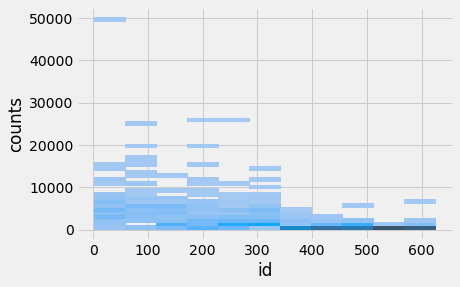

In [130]:
stations=Table.read_table("Divvy_Stations_2017_Q3Q4.csv")
station_list_full=stations['id'].tolist()
A=[]
for i in station_list_full:
    A.append(Q3_df['trip_id'][Q3_df['from_station_id']==i].count())
Q3_as={'id':station_list_full,'counts':A}
Q3_count_df=pd.DataFrame(Q3_as)
sns.histplot(x='id',y='counts',data=Q3_count_df);

### By counting all the times that each station serves as the start station and plotting them in one chart, it can be easily observed that different stations have different levels of demand. The asymmetry of demand requires manual bike reposition. This need will later be incorporated in the linear model. 

# Section_C

## Findings

#### In order to efficiently boost our company’s potential revenue, we want to find some useful information on what we need to improve. 

- While our main target group is the subscriber, which takes 89% of our total customers, the passengers use much fewer of our product, only taking about 11%. Based on the results, our bike’s vacancy rate is too high to max our profit, only developing 2% of bike availability. 
- In addition, the bike by population percentage is relatively small compared to other big cities, making it hard to meet people’s demand.

#### Therefore, we will consider the following aspects: 

- We want to attract more subscribers, while we can decrease the member fee so more people will join our program. 
- We can perform marketing strategies to increase the visibility of our service and increase the usage of our bikes.
- We can also add more variation of membership to meet different people’s use demand, and find some sponsorship to expand our service range.

# 3
# Linear Program Models


## STEP_1: Assumptions

### 1. Outliers

We remove the trips that has duration above 1440(a day) minutes. The bikes with trips above 1440 mins may encounter in stealing or other accidents that we don't need to consider. The trip with duration_time above 1440 only occupy about 10% of the overall data, so removing them does not analyze the problem (case).

### 2. Station Popularity

In [77]:
stations=Table.read_table("Divvy_Stations_2017_Q3Q4.csv")

# Total Number of Stations
print('Total number of stations is: ',stations.num_rows)

# Calculating sum of docks
total = sum(stations.column('dpcapacity'))
print('Total number of docks is:',total)

# Calculating average of dock capacity
ave= round(sum(stations.column('dpcapacity'))/len(stations.column('dpcapacity')))
print('Average number of docks is:',ave)

print('Two stations in the dataset have a capacity of 0 dock, which may be caused by system error.')

Total number of stations is:  585
Total number of docks is: 10216
Average number of docks is: 17
Two stations in the dataset have a capacity of 0 dock, which may be caused by system error.


In [78]:
stations.sort('dpcapacity').show(2)

id,name,city,latitude,longitude,dpcapacity,online_date,Unnamed: 7
581,Commercial Ave & 83rd St,Chicago,41.7446,-87.5512,0,5/27/2016 11:33,nan
582,Phillips Ave & 83rd St,Chicago,41.7447,-87.5661,0,5/27/2016 11:34,nan


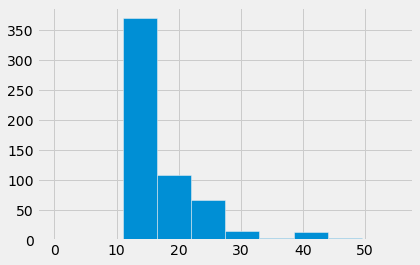

In [79]:
# Examing the distribution of station capacity 
plots.hist(stations["dpcapacity"]);

In [80]:
ave= sum(stations.column('dpcapacity'))/len(stations.column('dpcapacity'))
print('Average station capacity is :',round(ave))

Average station capacity is : 17


**Assumption:** When they are built, stations are constructed with initial capacities that reflect their popularity. For example, the capacity of station 6, situated in the heart of Chicago -Dusable Harbor - has the highest capacity of all which is 55 docks. 

- The stations capacities have an average of 17 docks, we divide the station data set into two by grouping all stations with more than 20 docks and all stations with fewer than 20 docks.

In [81]:
high_popularity = []
low_popularity = []
for i in range(stations.num_rows):
    if stations.column('dpcapacity')[i] <= 17:
        low_popularity.append(stations.column('id')[i])
    elif stations.column('dpcapacity')[i] > 17:
        high_popularity.append(stations.column('id')[i])

In [82]:
# There are 213 stations with high popularity
print('number of high popularity stations:',len(high_popularity))


high_sum = 0
for station_ID in high_popularity:
   high_sum +=  stations.where('id',station_ID)[5][0]
print('High popularity stations total capacity:',high_sum)

number of high popularity stations: 213
High popularity stations total capacity: 5086


In [83]:
# There are 372 stations with low popularity
print('Number of low popularity stations:',len(low_popularity))

# Total number of dock capacity at low popularity stations.
low_sum = 0
for station_ID in low_popularity:
   low_sum +=  stations.where('id',station_ID)[5][0]
print('Low popularity stations total capacity:',low_sum)

Number of low popularity stations: 372
Low popularity stations total capacity: 5130


**The beginning inventory lower bound is calculated by maintaing a total beginning inventory around 6471 bikes.** 

Noted: actual numbers of bikes will be calculated with rounding.

- We assume high popularity stations and low popularity stations should have different levels of inventory requirement and should have a combined number of approximately 6471 bikes.

In [84]:
high_begin = 0.73
low_begin = 0.51

#### These are the rates we designed. 

In [85]:
high_rate = 0.76
low_rate = 0.5
# With a total of approximately 6471 bikes 
print( round(high_rate*high_sum+low_rate*low_sum))

6430


**To account for flexibility, we design the ratio be a range.** 

For both groups, there are a upper bound and a lower bound for the inventory as a fraction of total capacity. When the ending inventory arrives at the lower bound, there is a need to move bikes in to guarantee the supply of that station; when the inventory reaches the upper bound, bikes should be moved out from that station to provide space for other bikes to move in.

**The ratio of inventory for high popularity and low popularity stations is calculated by maitaining both ( lb x high_sum + ub x low_sum = ub x high_sum + lb x low_sum = 6471 ).**

Noted: actual numbers of bikes will be calculated with rounding.

In [86]:
high_range = (0.67,0.83)
low_range = (0.44,0.6)

#### We then give each station ID its ratio by building a dictionary.

In [119]:
ratio = {}
for ID in high_popularity: 
    ratio[ID] = (0.67,0.83)
for ID in low_popularity: 
    ratio[ID] = (0.44,0.6)

In [120]:
print(ratio[2])
print(ratio[14])

(0.67, 0.83)
(0.44, 0.6)


## STEP_2: Creating A Gurobi Object

In [89]:
model = Model('Divvy')

Set parameter Username
Academic license - for non-commercial use only - expires 2022-10-27


## STEP_3 Defining Decision Variables

### Decision Variables

We define the following decision variables:

1. $x_{ijt}$: number of bikes to move from area $i\in Z$ to area $j\in Z$ at time $t\in T$
2. $w_{it}$ : ending inventory of station_list[i] at t
3. $T_{(t)}$ : number of trailer at t

In [90]:
Q3=Table.read_table('D:\Lecture5\Divvy_Trips_2017_Q3.csv')
Q4=Table.read_table('D:\Lecture5\Divvy_Trips_2017_Q4.csv')

stations_tb=Table.read_table('D:\Lecture5\Divvy_Stations_2017_Q3Q4.csv').sample(100,with_replacement=False)
stations_tb.to_csv('D:\Lecture5\SAMPLE_station.csv') #export csv
stations_df=pd.read_csv(r'D:\Lecture5\SAMPLE_station.csv')
station_list=stations_df['id'].tolist()
station_list.sort()

#### Sampling of 100 stations

In [91]:
N=100

In [92]:
X = {} 
W = {}
T = {}


for m in np.arange(N):
    for n in np.arange(N):
        for t in np.arange(24):
            i=station_list[m]
            j=station_list[n]
            X[(i,j,t)] = model.addVar(lb = 0)
            
for i in station_list:
    for t in np.arange(24):
        W[(i,t)] = model.addVar(lb = 0)
        
for t in np.arange(24):
    T[t]=model.addVar(lb=0)


## STEP_4: Parameters

### Parameters calculated from the given data set
**current_bike** = the number of current bikes

**current_station** = the number of current stations

**current_cap** = the number of current capacities

**current_trailer** = the number of current trailers

### Other parameters

**driver_salary** = a trailer driver's salary

**gasoline_fee** = the cost of driving one kilometer

**trailer_price** = the price of one trailer

**trailer_capacity** = the number of bikes trailed moved in one time. 

**Depreciation_cost_per_day** = the depreciation cost of one trailer per day

**Fuel_price_bike_km** = the cost on fuel to reposition one bike per kilometer

**hourly_wage** = the hourly wage of one driver in CAD

### Sets
1. $T =\{0,1,2,3,...,23\}$: Hours of the day
2. $J =\{2,3,5,...625\}$: Station list.
3. $D[(i,j)]:Distance from station i to station j .
4. $Y[(i,j,t)]: The number of bikes customer riding from station i to station j in hour t. 


In [93]:
#Parameters calculated from the given data set#
current_bike = 6471
current_station = 100
current_cap = 10216
current_trailer = 10

#other parameters#
driver_salary = 1000
bike_maintain_fee = 100
trailer_cap = 20
trailer_price = 32000
# Calculating Depreciation_cost_per_day: 32000 CAD/ 5 years/ 365 days
depreciation_cost_day = 17.5
# Calculating Fuel_price_bike_km: 11.7607292 ( * 1.432) L/ 100km / 25 bikes = 0.0067 CAD / km / bike
Fuel_price_bike_km = 0.0067
hourly_wage = 25
Hour = 24
gasoline_fee=0.01


#### The distance from i to j

In [94]:
D={}
for m in np.arange(N):
    for n in np.arange(N):
        for t in np.arange(24):
            i=station_list[m]
            j=station_list[n]
            id_i_latitude = stations['latitude'][m]
            id_i_longitude = stations['longitude'][m]
            id_j_latitude = stations['latitude'][n]
            id_j_longitude = stations['longitude'][n]
            latitude_d=hs.haversine((id_i_latitude,0),(id_j_latitude,0))
            longititude_d=hs.haversine((0,id_i_longitude),(0,id_j_longitude)) 
            D[(i,j)]=(latitude_d+longititude_d)

#### This is the process for Y[(i, j, t)]

- This parameter resembles the number of bikes that customers ride from station i to j at time t. 
- We want to include this parameter because while we are repositioning bikes, customers are riding them at the same time. 
- Our original plan is to use all records in quarter three and quarter four,  but due to the large set of data, we decided to sample, and finally reduced the sample size to 7, where we guarantee that we get a day from each month and we select a whole week from Monday to Sunday.

In [95]:
#function we gonna use. 
def get_hour_Q3(time):
    return int(time[-8:-6])

def get_hour_Q4(time):
    if time[-5]=="":
        hour=int(time[-4])
    else:
        hour=int(time[-5:-3])
    return hour

def get_month(time):
    if time[1]=='/':
        month=time[0]
    else:
        month=time[0:2]
    return int(month)

def get_date(time):
    if time[1]=='/':
        if time[3]=='/':
            date=time[2]
        elif time[4]=='/':
            date=time[2:4]
    else:
        if time[4]=='/':
            date=time[3]
        elif time[5]=='/':
            date=time[3:5]
    return int(date)

In [96]:
Q3=Q3.where(Q3['tripduration']<=4500)
Q4=Q4.where(Q4['tripduration']<=3500)

In [97]:
#add column of start time and end time 
Q3_start_array=Q3.apply(get_hour_Q3,'start_time')
Q3=Q3.with_columns("start_time_hour",Q3_start_array)
Q3_hour_array=Q3.apply(get_month,'start_time')
Q3=Q3.with_columns('month',Q3_hour_array)
Q3_date_array=Q3.apply(get_date,'start_time')
Q3=Q3.with_columns('date',Q3_date_array)

In [98]:
Q3.to_csv('D:\Lecture5\Q3.csv') #export csv
Q3_df=pd.read_csv(r'D:\Lecture5\Q3.csv')
Q3_df=Q3_df[['trip_id','from_station_id','to_station_id','start_time_hour','month','date']]

In [99]:
#change Q4 table to dataframe 
Q4_start_array=Q4.apply(get_hour_Q4,'start_time')
Q4=Q4.with_columns("start_time_hour",Q4_start_array)
Q4_month_array=Q4.apply(get_month,'start_time')
Q4_date_array=Q4.apply(get_date,'start_time')
Q4=Q4.with_columns('month',Q4_month_array)
Q4=Q4.with_columns('date',Q4_date_array)

In [100]:
Q4.to_csv('D:\Lecture5\Q4.csv') #export csv
Q4_df=pd.read_csv(r'D:\Lecture5\Q4.csv')
Q4_df=Q4_df[['trip_id','from_station_id','to_station_id','start_time_hour','month','date']]

- Week we choose from each month: np.random.choice(180,7)
- The result is 155 133 52 80 59 170 166. Therefore we choose these days from Q3 and Q4, including each month of two quarters and each day of week.

In [101]:
sample1=Q3_df[(Q3_df['month']==7)&(Q3_df['date']==14)]#Friday
sample2=Q3_df[(Q3_df['month']==8)&(Q3_df['date']==29)]#Tuesday
sample3=Q3_df[(Q3_df['month']==8)&(Q3_df['date']==21)]#Monday
sample4=Q3_df[(Q3_df['month']==9)&(Q3_df['date']==20)]#Wednesday
sample5=Q4_df[(Q4_df['month']==10)&(Q4_df['date']==19)]#Thursday
sample6=Q4_df[(Q4_df['month']==11)&(Q4_df['date']==11)]#Saturday
sample7=Q4_df[(Q4_df['month']==12)&(Q4_df['date']==3)] #Sunday

Q3_Q4_sample=pd.concat([sample1,sample2,sample3,sample4,sample5,sample6,sample7],axis=0)

In [102]:
Y={}

for i in station_list:
    for j in station_list:
        for t in np.arange(24):
            Y[(i,j,t)]=round((Q3_Q4_sample['trip_id'][(Q3_Q4_sample['from_station_id']==i) & 
                                        (Q3_Q4_sample['to_station_id']==j)&
                                        (Q3_Q4_sample['start_time_hour']==t)].count()/7))+1 

- As we generate data from both quarter three and quarter four, the number of bikes customers ride away should be lower than the actual situation in quarter 3 and larger than quarter 4.

## STEP_5: Constraints

*1. The total number of bikes moved at time $t$ has to be less than 200:*
$$\sum_{i\in J}\sum_{j\in J}x_{ijt}\leq 200,\quad \forall t\in T$$

In [103]:
bike_moving={}
for t in np.arange(24):
            bike_moving[t]=model.addConstr(quicksum(X[(i,j,t)] for i in station_list for j in station_list)<=200)

*2. Ending inventory constraint:*

$$W_{ij}=W_{i,t-1}+\sum_{j \in J}X_{jit}-\sum_{j \in J}X_{ijt}+\sum_{j \in J}Y_{jit}-\sum_{j \in J}Y_{ijt},\forall i \in I, \forall t \in T$$

In [104]:
#We want to create the list for the begin inventory,lower bound and upper bound 
import pandas as pd
Stations8=stations_df.sort_values(by='dpcapacity',ascending=True)
Stations9=stations_df[['id','dpcapacity']]
Stations10_high=Stations9[Stations9.dpcapacity>17]
Stations10_low=Stations9[Stations9.dpcapacity<=17]

#### Beginning Inventory

In [105]:
Stations10_high_2=Stations10_high.assign(Begin_Inventory=round(Stations10_high.dpcapacity*0.73))
Stations10_low_2=Stations10_low.assign(Begin_Inventory=round(Stations10_low.dpcapacity*0.51))
Station_begin_inventory=pd.concat([Stations10_high_2,Stations10_low_2],axis=0)
Station_begin_inventory=Station_begin_inventory.sort_values(by='id',ascending=True)
begin_inventory_list=Station_begin_inventory['Begin_Inventory'].to_list()
begin_inventory=[]
for i in begin_inventory_list:
    begin_inventory.append(int(i))

#### Upper Bound

In [106]:
Stations10_high_3=Stations10_high_2.assign(Upper_bound=round(Stations10_high_2.dpcapacity*0.83))
Stations10_low_3=Stations10_low_2.assign(Upper_bound=round(Stations10_low_2.dpcapacity*0.6))
Stations_upperbound=pd.concat([Stations10_high_3,Stations10_low_3],axis=0)
Stations_upperbound=Stations_upperbound.sort_values(by='id',ascending=True)
Upperbound_list=Stations_upperbound['Upper_bound'].to_list()
Upperbound=[]
for i in Upperbound_list:
    Upperbound.append(int(i))

#### Lower Bound

In [107]:
Stations10_high_4=Stations10_high_2.assign(Lower_bound=round(Stations10_high_2.dpcapacity*0.67))
Stations10_low_4=Stations10_low_2.assign(Lower_bound=round(Stations10_low_2.dpcapacity*0.44))
Stations_lowerbound=pd.concat([Stations10_high_4,Stations10_low_4],axis=0)
Stations_lowerbound=Stations_lowerbound.sort_values(by='id',ascending=True)
Lowerbound_list=Stations_lowerbound['Lower_bound'].to_list()
Lowerbound=[]
for i in Lowerbound_list:
    Lowerbound.append(int(i))

#### Inventory Constraint

In [108]:
#Add Ending Inventory Constraint:
ending_inventory={}
for m in np.arange(N):
    i=station_list[m]
    ending_inventory[(i,0)]=model.addConstr(W[(i,0)]==begin_inventory[m])
    for t in np.arange(1,24):
        ending_inventory[(i,t)]=model.addConstr(W[(i,t)]==W[(i,t-1)]+quicksum(X[(j,i,t)]-X[(i,j,t)] +Y[(j,i,t)]-Y[(i,j,t)]for j in station_list))

#Add constraint for lower bound for the ending inventory (already be polished in the list: Lowerbound)
        ending_inventory[(i,t)]=model.addConstr(W[(i,t)]>=Lowerbound[m])

#Add constraint for upper bound for the ending inventory (already be polished in the list: Upperbound)   
        ending_inventory[(i,t)]=model.addConstr(W[(i,t)]<=Upperbound[m])

*3. Trailer limit constraint:*

As one trailer has the capacity of moving 20 bikes,  to control our cost on trailers and drivers, the number of trailers should be limited to less than 10

In [109]:
#assume that the capaity of each trailer is 25 bike
trailer_number_constrain={}

#trailer needs to satisfy the demand of moving bikes
for t in np.arange(24):
    trailer_number_constrain[t]=model.addConstr(T[t]*trailer_cap>=quicksum(X[(i,j,t)] for i in station_list for j in station_list))

            #maximum constraint for the trailer
#(we have constraint for The total number of bikes moved at time t has to be less than 200) )
    trailer_number_constrain[t]=model.addConstr(T[t]<=200/trailer_cap)

## STEP_6: Deriving Objective Function Process

#### The fuel cost spend on repositioning

In [110]:
Fuel_cost=quicksum(X[(i,j,t)]*D[(i,j)]*Fuel_price_bike_km 
                   for i in station_list for j in station_list for t in np.arange(24))

#### The depreciation cost for using trailer

In [111]:
Depreciation_cost=quicksum(T[t] for t in np.arange(24))*depreciation_cost_day/24

#### The salary for the trailer driver

In [112]:
Wage = quicksum(T[t] for t in np.arange(24))*hourly_wage 

## STEP_7: Objective Function

### The objective function minimizes the cost of moving bikes:

$$\min Fuel\_cost +\ Depreciation\_cost +\ Wage $$

In [113]:
obj = Fuel_cost + Depreciation_cost + Wage
model.setObjective(obj, GRB.MINIMIZE)
model.optimize()

Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 7072 rows, 242424 columns and 944748 nonzeros
Model fingerprint: 0xf166161a
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [9e-04, 3e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+02]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 4726 rows and 12401 columns
Presolve time: 1.10s
Presolved: 2346 rows, 230023 columns, 915323 nonzeros

Ordering time: 0.02s

Barrier statistics:
 AA' NZ     : 1.207e+05
 Factor NZ  : 3.427e+05 (roughly 100 MB of memory)
 Factor Ops : 5.305e+07 (less than 1 second per iteration)
 Threads    : 6

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   4.99163939e+04 -7.76006641e+03  4.66e+04 1.32e+00  4.13e+01     1

In [114]:
model.optimize()

Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 7072 rows, 242424 columns and 944748 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [9e-04, 3e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+02]

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective  5.982620815e+01


## Model_Findings

Initially we used the whole station list, but we encountered hardware and license problems, so we finally sampled 100 stations from the total 585 stations.

**The results:**
- The total cost for repositioning bikes per day is 18 dollars, and if we want to estimate for the cost for 585 stations, we expand the 100*100 map to 600*600 dimension map, so we estimate the total cost is about 18*36 = 648 dollars. 
- The different samples would generate different results. 

# Sensitivity_Analysis

## A - Assumptions: 
### Sensitivity Test 1:
#### The initial inventory alert ratios are designed to be high_range = (0.67,0.83) ; low_range = (0.44,0.6). We want to examine the impact on the model if we make the range wider. This change will make the model less sensitive. For example, the model was initially instructed to move bikes into station i if the inventory gets under 4 bikes, if we make the range wider, the model will now be instructed to move bikes into station i when there are 2 bikes. 

#### The new range is designed under similar principle with the initial range. The ratio of inventory for high popularity and low popularity stations is calculated by maitaining both ( lb x high_sum + ub x low_sum = ub x high_sum + lb x low_sum = 6471 ).

#### Note: actual numbers of bikes will be calculated with rounding.

In [124]:
print(high_sum,low_sum)

5086 5130


In [126]:
# New Range. Wider - Lower lb and Higher ub
# The results of the two following equations should be approximately 6471
high_range=(0.47,0.9)
low_range=(0.37,0.8)
print(high_range[1] * high_sum+  low_range[0] * low_sum) 
print(high_range[0] * high_sum+  low_range[1] * low_sum)

6475.5
6494.42


### Sensitivity Test 2:

### In the initial model the total number of bikes in time t is designed to be 200 bikes, calculated by 10(trailers)x 20(moving bikes capacity of one trailer ). Now we would like to examine the change in model results due to changes  in this paramter. 

##  B - Define the sensitivity test function 

In [115]:
def sensitivity_1(boundary_bike,high_upper,low_upper,high_lower,low_lower):
      
    #decision variable
    X = {} 
    W = {}
    T = {}
    
    #create decision variable
    for m in np.arange(100):
        for n in np.arange(100):
            for t in np.arange(24):
                i=station_list[m]
                j=station_list[n]
                X[(i,j,t)] = model.addVar(lb = 0)
            
    for i in station_list:
        for t in np.arange(24):
            W[(i,t)] = model.addVar(lb = 0)
        
    for t in np.arange(24):
        T[t]=model.addVar(lb=0)
    
    
    #constraint
    #(1)the number of bike moving
    bike_moving={}
    for t in np.arange(24):
        bike_moving[t]=model.addConstr(quicksum(X[(i,j,t)] for i in station_list for j in station_list)<=boundary_bike)

    #(2)inventory
    #We want to create the list for the begin inventory,lower bound and upper bound 
    Stations8=stations_df.sort_values(by='dpcapacity',ascending=True)
    Stations9=stations_df[['id','dpcapacity']]
    Stations10_high=Stations9[Stations9.dpcapacity>17]
    Stations10_low=Stations9[Stations9.dpcapacity<=17]

    #Beginning Inventory
    Stations10_high_2=Stations10_high.assign(Begin_Inventory=round(Stations10_high.dpcapacity*0.73))
    Stations10_low_2=Stations10_low.assign(Begin_Inventory=round(Stations10_low.dpcapacity*0.51))
    Station_begin_inventory=pd.concat([Stations10_high_2,Stations10_low_2],axis=0)
    Station_begin_inventory=Station_begin_inventory.sort_values(by='id',ascending=True)
    begin_inventory_list=Station_begin_inventory['Begin_Inventory'].to_list()
    begin_inventory=[]
    for i in begin_inventory_list:
        begin_inventory.append(int(i))

    #UpperBound
    Stations10_high_3=Stations10_high_2.assign(Upper_bound=round(Stations10_high_2.dpcapacity*high_upper))
    Stations10_low_3=Stations10_low_2.assign(Upper_bound=round(Stations10_low_2.dpcapacity*low_upper))
    Stations_upperbound=pd.concat([Stations10_high_3,Stations10_low_3],axis=0)
    Stations_upperbound=Stations_upperbound.sort_values(by='id',ascending=True)
    Upperbound_list=Stations_upperbound['Upper_bound'].to_list()
    Upperbound=[]
    for i in Upperbound_list:
        Upperbound.append(int(i))
    #Upperbound=stations['dpcapacity'].to_list()#11.27更改

    #Lowerbound
    Stations10_high_4=Stations10_high_2.assign(Lower_bound=round(Stations10_high_2.dpcapacity*high_lower))
    Stations10_low_4=Stations10_low_2.assign(Lower_bound=round(Stations10_low_2.dpcapacity*low_lower))
    Stations_lowerbound=pd.concat([Stations10_high_4,Stations10_low_4],axis=0)
    Stations_lowerbound=Stations_lowerbound.sort_values(by='id',ascending=True)
    Lowerbound_list=Stations_lowerbound['Lower_bound'].to_list()
    Lowerbound=[]
    for i in Lowerbound_list:
        Lowerbound.append(int(i))
    
    #Inventory constraint

    #Add Ending Inventory Constraint:
    ending_inventory={}
    for m in np.arange(100):
        i=station_list[m]
        ending_inventory[(i,0)]=model.addConstr(W[(i,0)]==begin_inventory[m])
        for t in np.arange(1,24):
            ending_inventory[(i,t)]=model.addConstr(W[(i,t)]==W[(i,t-1)]+quicksum(X[(j,i,t)]-X[(i,j,t)] +Y[(j,i,t)]-Y[(i,j,t)]for j in station_list))

    #Add constraint for lower bound for the ending inventory (already be polished in the list: Lowerbound)
            ending_inventory[(i,t)]=model.addConstr(W[(i,t)]>=Lowerbound[m])

    #Add constraint for upper bound for the ending inventory (already be polished in the list: Upperbound)   
            ending_inventory[(i,t)]=model.addConstr(W[(i,t)]<=Upperbound[m])
        
    #(3)number of trailer
    #assume that the capaity of each trailer is 20 bike
    trailer_number_constrain={}
    #trailer needs to satisfy the demand of moving bikes
    for t in np.arange(24):
        trailer_number_constrain[t]=model.addConstr(T[t]*trailer_cap>=quicksum(X[(i,j,t)] for i in station_list for j in station_list))

    #maximum constraint for the trailer
    #(we have constraint for The total number of bikes moved at time t has to be less than 200) )
        trailer_number_constrain[t]=model.addConstr(T[t]<=200/trailer_cap)
    
    
    #Objective process
    #repositioning cost
    #Wage+Fuel_cost+Depreciation_cost

    #The Fuel cost spend on repostioning
    Fuel_cost_sensitivity=quicksum(X[(i,j,t)]*D[(i,j)]*Fuel_price_bike_km 
                   for i in station_list for j in station_list for t in np.arange(24))

    #The depreciation cost for using trailer
    Depreciation_cost_sensitivity=quicksum(T[t] for t in np.arange(24))*depreciation_cost_day/24

    #The salary for the trailer driver
    Wage_sensitivity = quicksum(T[t] for t in np.arange(24))*hourly_wage 
    
    
    #Objective function
    obj = Fuel_cost_sensitivity + Depreciation_cost_sensitivity + Wage_sensitivity
    model.setObjective(obj, GRB.MINIMIZE)
    model.optimize()
    
    return model.objVal

## 1. Sensitivity Test 1 

| Variable | Value | 
| --- | --- | 
| High Popularity Range |  <font color='red'>(0.47,0.9)</font> | 
| High Popularity Range| <font color='red'>(0.38,0.8)</font> |
| Number of moved bikes at time t  | 200 | 


In [116]:
sensitivity_1(200,0.9,0.8,0.47,0.37)

Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 14144 rows, 484848 columns and 1889496 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [9e-04, 3e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+02]
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   2.034200e+04   0.000000e+00      0s
    4685    1.5515312e+01   0.000000e+00   0.000000e+00      0s

Solved in 4685 iterations and 0.45 seconds (0.18 work units)
Optimal objective  1.551531189e+01


15.51531188753495

## Observation from sensitivity test 1

### As expected, the cost of repositioning drops from 59 CAD to 15 CAD. This is explained by the decrease in the model's alert level to changes in inventory. The model is now less often instructed to move bikes. The Divvy company can design their own inventory ratios according to actual situations. 

## 2. Sensitivity Test 2

| Variable | Value | 
| --- | --- | 
| High Popularity Range |  (0.6,0.83)| 
| High Popularity Range| (0.44,0.67) |
| Number of moved bikes at time t  |  <font color='red'>100/50</font> | 

In [117]:
sensitivity_1(100,0.83,0.6,0.67,0.44)

Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 21216 rows, 727272 columns and 2834244 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [9e-04, 3e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+02]
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   2.646000e+04   0.000000e+00      0s
    5229    5.9826208e+01   0.000000e+00   0.000000e+00      1s

Solved in 5229 iterations and 1.10 seconds (0.82 work units)
Optimal objective  5.982620815e+01


59.8262081514152

In [118]:
sensitivity_1(50,0.83,0.6,0.67,0.44)

Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 28288 rows, 969696 columns and 3778992 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [9e-04, 3e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+02]
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   2.646000e+04   0.000000e+00      0s
    5158    5.9826208e+01   0.000000e+00   0.000000e+00      1s

Solved in 5158 iterations and 1.09 seconds (0.83 work units)
Optimal objective  5.982620815e+01


59.82620815141521

## Observation from sensitivity test 2

### The repositioning costs do not change much if the total number of bikes to be moved within time t is now restricted to 100 or 50, meaning the need for bikes does not have a total number exceeding the parameter. 

# 4

## Conclusion and Managerial Insights

In conclusion, this project gave us insight into Divvy, the bike-sharing system, through exploration of three key topics: the Divvy user base and usage patterns, the efficiency of Divvy operations, and the per-bike unit economics.

Based on our linear program model, we can conclude that with a sampling of 100 stations, the daily repositioning cost is 18 dollars. We estimate the cost for the total station population of 585 stations to be 648 dollars per day. 

From the result of the sensitivity reports, we can see, if we set a wider lower bound and upper bound ratio, the daily cost will be substantially lower to 2 dollars per day. This result makes intuitive sense because the model is now less sensitive. For example, with the initial ratio, we would only move bikes when there are 4 bikes left in the station, but now bikes should be moved in when there are 2 bikes left.

In terms of managerial insights, understanding the user-level ridership patterns is crucial to minimize the company’s repositioning cost. Therefore, we should further analyze the data across a longer time frame instead of the two quarters to discover more detailed usage patterns such as the bike downtime, relocation patterns, and availability of bikes at high usage stations. Such that, we would get better results in the conversion and retention rates as well as the average number of rides by users per week. This would help us to optimize our pricing model to increase unit economics and revenue and reduce the expenses. 

We would also increase the revenue by maximizing ridership, that we can implement referral incentives to users, such as providing special offers on the pricing and trip duration if they invite friends to ride bikes together. We can also send out surveys to get feedback from the users, to improve the design of our bikes to attract more one-time riders, for instance, adding mobile phone or GPS holders on the handle bar.

These further investigations and improvements would help the company to not only improve cost-efficiency on the system operations, but also increase ridership to maximize the profit in the end.

# 5

## Author Contributions

All members of the team were a part of the designing and structuring of the model. Xinyue Zhang and Zhixuan Ren coded and solved the LP. All members worked on the presentation, wrote the report, and explained the findings.

<h1><center>Thank you for reading our report!</center></h1>